## Example

A complete example of how to use the sklearn_gbmi module.

In [1]:
import numpy as np

import pandas as pd

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.inspection.partial_dependence import plot_partial_dependence

In [3]:
from sklearn_gbmi import *

In [4]:
DATA_COUNT = 10000

RANDOM_SEED = 137

TRAIN_FRACTION = 0.9

Fabricate a data set of *DATA_COUNT* samples of three continuous predictor variables and one continuous target variable:

* *x0*, *x1*, and *x2* are independent random variables uniformly distributed on the unit interval.

* *y* is *x0*∗*x1* + *x2* + *e*, where *e* is a random variable normally distributed with mean 0 and variance 0.01.

So the relationship between the predictor variables and the target variable features an interaction between two of the former, namely *x0* and *x1*.

In [5]:
np.random.seed(RANDOM_SEED)

In [6]:
xs = pd.DataFrame(np.random.uniform(size = (DATA_COUNT, 3)))
xs.columns = ['x0', 'x1', 'x2']

In [7]:
y = pd.DataFrame(xs.x0*xs.x1 + xs.x2 + pd.Series(0.1*np.random.randn(DATA_COUNT)))
y.columns = ['y']

Train a gradient-boosting regressor on the first *TRAIN_FRACTION* of the data set, and test it on the rest.

In this toy analysis, hyperparameter tuning is omitted. However, note that the default value of the hyperparameter *max_depth* is 3, so the regressor could represent interactions among up to three predictor variables.

In [8]:
train_ilocs = range(int(TRAIN_FRACTION*DATA_COUNT))

test_ilocs = range(int(TRAIN_FRACTION*DATA_COUNT), DATA_COUNT)

In [9]:
gbr_1 = GradientBoostingRegressor(random_state = RANDOM_SEED)

In [10]:
gbr_1.fit(xs.iloc[train_ilocs], y.y.iloc[train_ilocs])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=137, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
gbr_1.score(xs.iloc[test_ilocs], y.y.iloc[test_ilocs])

0.9226936169364505

Inspect the feature importances and plot the partial dependences on single predictor variables and pairs of predictor variables. We expect roughly equal feature importances and roughly linear partial dependences except on the pair (*x0*, *x1*), which combine nonadditively.

In [12]:
gbr_1.feature_importances_

array([0.18417467, 0.18540617, 0.63041915])

(<Figure size 432x288 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a18c8ad10>])

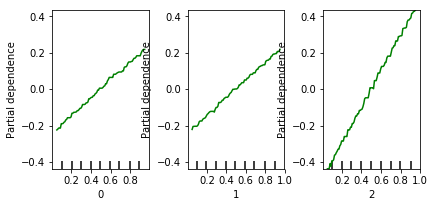

In [13]:
plot_partial_dependence(gbr_1, xs.iloc[train_ilocs], [0, 1, 2])

(<Figure size 432x288 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a18efa790>])

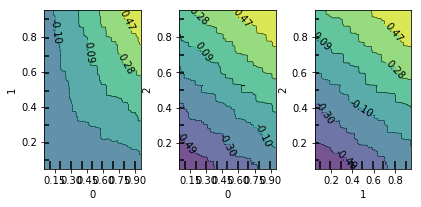

In [14]:
plot_partial_dependence(gbr_1, xs.iloc[train_ilocs], [(0, 1), (0, 2), (1, 2)])

Compute the two-variable *H* statistic of each pair of predictor variables. We expect the value for (*x0*, *x1*) to be much greater than the values for (*x0*, *x2*) and (*x1*, *x2*).

In [15]:
h_all_pairs(gbr_1, xs.iloc[train_ilocs])

{('x0', 'x1'): 0.36936614837698983,
 ('x0', 'x2'): 0.03148351340724796,
 ('x1', 'x2'): 0.04126283875437962}

Compute the *H* statistic of all three predictor variables. We expect the value to be relatively small.

In [16]:
h(gbr_1, xs.iloc[train_ilocs])

0.027507297585577455

For comparison, train a gradient-boosting regressor with the hyperparameter *max_depth* set to 1, which excludes all interactions among predictor variables. Because there actually is an interaction between *x0* and *x1*, we expect a loss of accuracy.

In [17]:
gbr_2 = GradientBoostingRegressor(random_state = RANDOM_SEED, max_depth = 1)

In [18]:
gbr_2.fit(xs.iloc[train_ilocs], y.y.iloc[train_ilocs])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=137, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
gbr_2.score(xs.iloc[test_ilocs], y.y.iloc[test_ilocs])

0.860980402113025

Trying to compute *H* statistics throws exceptions, reflecting the exclusion of interactions via *max_depth*.

In [20]:
h_all_pairs(gbr_2, xs.iloc[train_ilocs])

Exception: gbm.max_depth must be at least 2.